https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from MNIST_helper import plot_numbers, visualize_input
from keras.utils import to_categorical
folder = '/Users/julianganzabal/.kaggle/competitions/fashion-mnist-itba-lab-ml/'
x = np.load(folder+'train_images.npy')
y = np.loadtxt(folder+'train_labels.csv', delimiter=',', skiprows=1)
x_test = np.load(folder+'test_images.npy').reshape(x_test_.shape + (1,))
y_test = np.loadtxt('test_labels.csv', delimiter=',', skiprows=1)
y_test_categorical = to_categorical(y_test[:,0])
plot_numbers(x,range(150), columns=25, figsize=(20, 20))

NameError: name 'x_test_' is not defined

In [5]:
import keras
from cnn_models import get_model, get_model_2, get_model_3, get_model_4, 

from keras import backend as K

K.set_learning_phase(1) #set learning phase

In [6]:
model_1 = get_model()
# model.summary()
model_1.load_weights('cnn-1.hdf5')

In [7]:
model_2 = get_model_2()
# model.summary()
model_2.load_weights('cnn-2.hdf5')

In [9]:
model_4 = get_model_4()
model_4.load_weights('cnn-4.hdf5')
#model_4.summary()
#model_4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model_4.evaluate(x_test, y_test_categorical)

ValueError: Dimension 0 in both shapes must be equal, but are 3 and 6 for 'Assign_69' (op: 'Assign') with input shapes: [3,3,1,32], [6,1,3,3].

In [6]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model_4.layers])
layer_dict

{'Conv1': <keras.layers.convolutional.Conv2D at 0x11c07d128>,
 'Conv2': <keras.layers.convolutional.Conv2D at 0x11c1b3240>,
 'Conv3': <keras.layers.convolutional.Conv2D at 0x11c35bbe0>,
 'Conv4': <keras.layers.convolutional.Conv2D at 0x11c3ca898>,
 'activation_10': <keras.layers.core.Activation at 0x11c321710>,
 'activation_11': <keras.layers.core.Activation at 0x11c3ca240>,
 'activation_12': <keras.layers.core.Activation at 0x11c42de80>,
 'activation_9': <keras.layers.core.Activation at 0x11c11f7b8>,
 'batch_normalization_11': <keras.layers.normalization.BatchNormalization at 0x11c066c50>,
 'batch_normalization_12': <keras.layers.normalization.BatchNormalization at 0x11c10d128>,
 'batch_normalization_13': <keras.layers.normalization.BatchNormalization at 0x11c15fef0>,
 'batch_normalization_14': <keras.layers.normalization.BatchNormalization at 0x11c3a1710>,
 'batch_normalization_15': <keras.layers.normalization.BatchNormalization at 0x11c416ba8>,
 'dense_3': <keras.layers.core.Dense a

In [231]:
layer_dict['Conv1'].filters

6

In [214]:
from CNN_analysis_helper import plot_filter_coefs, plot_conv_filters

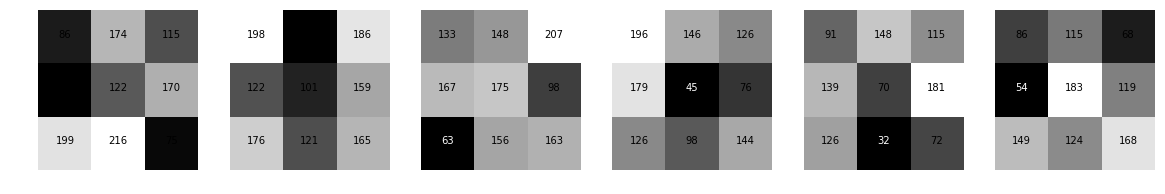

In [226]:
plot_filter_coefs('Conv2', model_4, starting_filt=32)

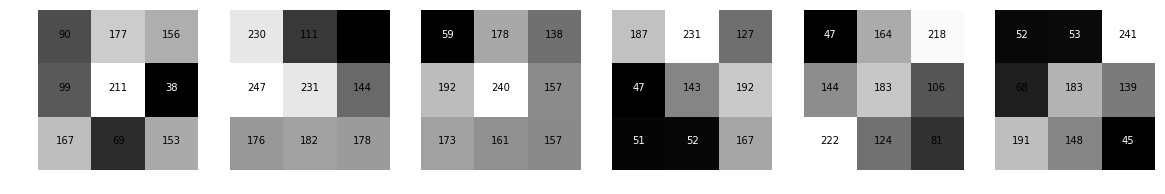

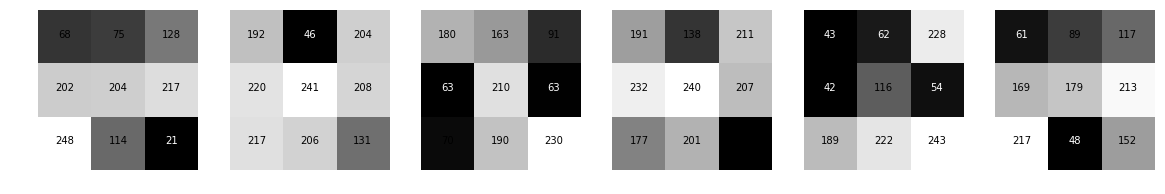

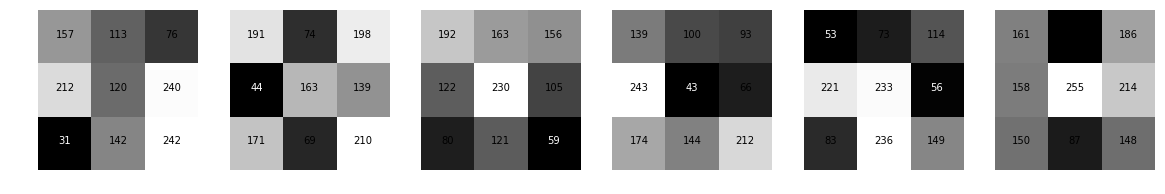

In [217]:
plot_filter_coefs('Conv1', model_4)
plot_filter_coefs('Conv1', model_4, starting_filt=6)
plot_filter_coefs('Conv1', model_4, starting_filt=12)

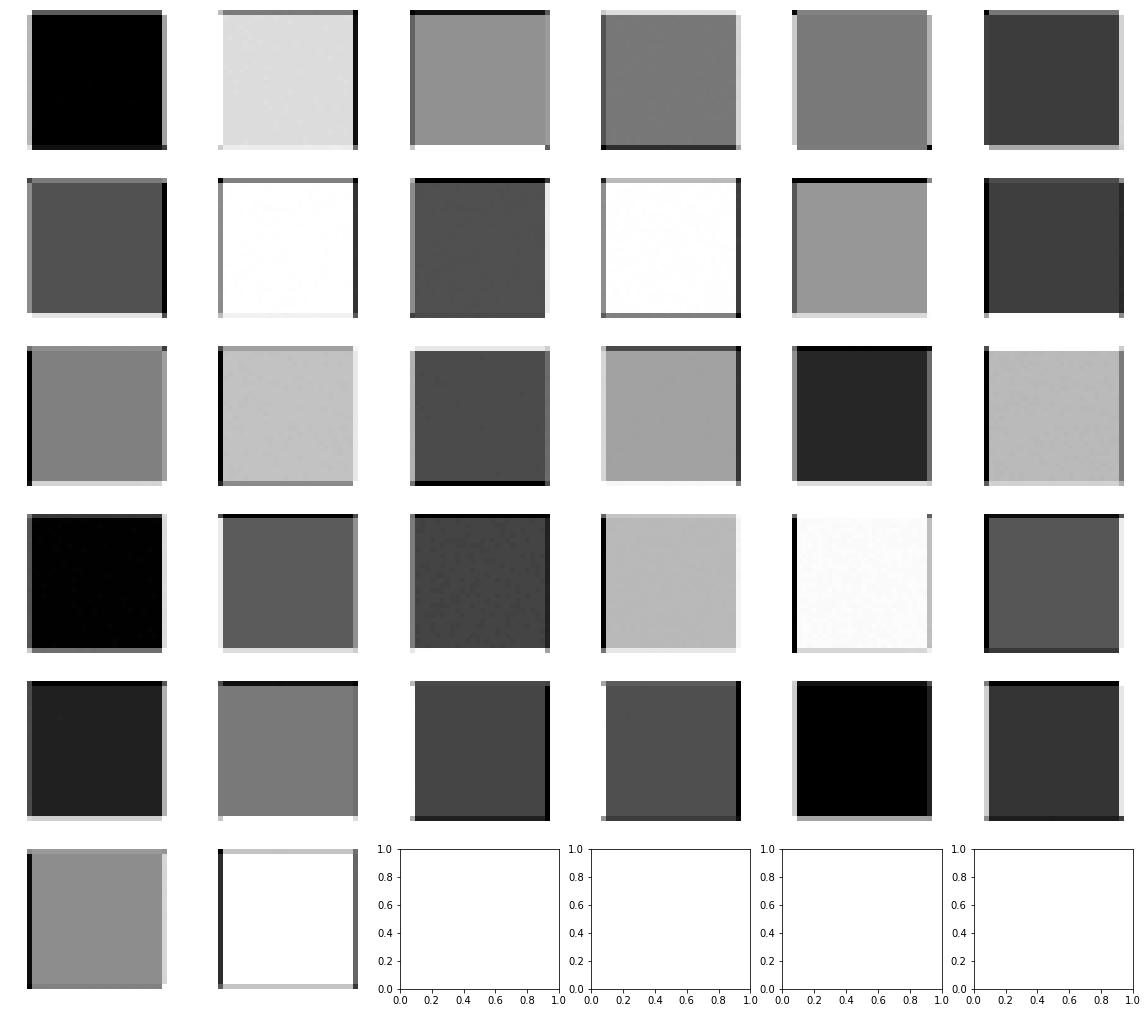

In [215]:
images = plot_conv_filters(model_4, 'Conv1', input_img_data, iterations=1500, step = 1)

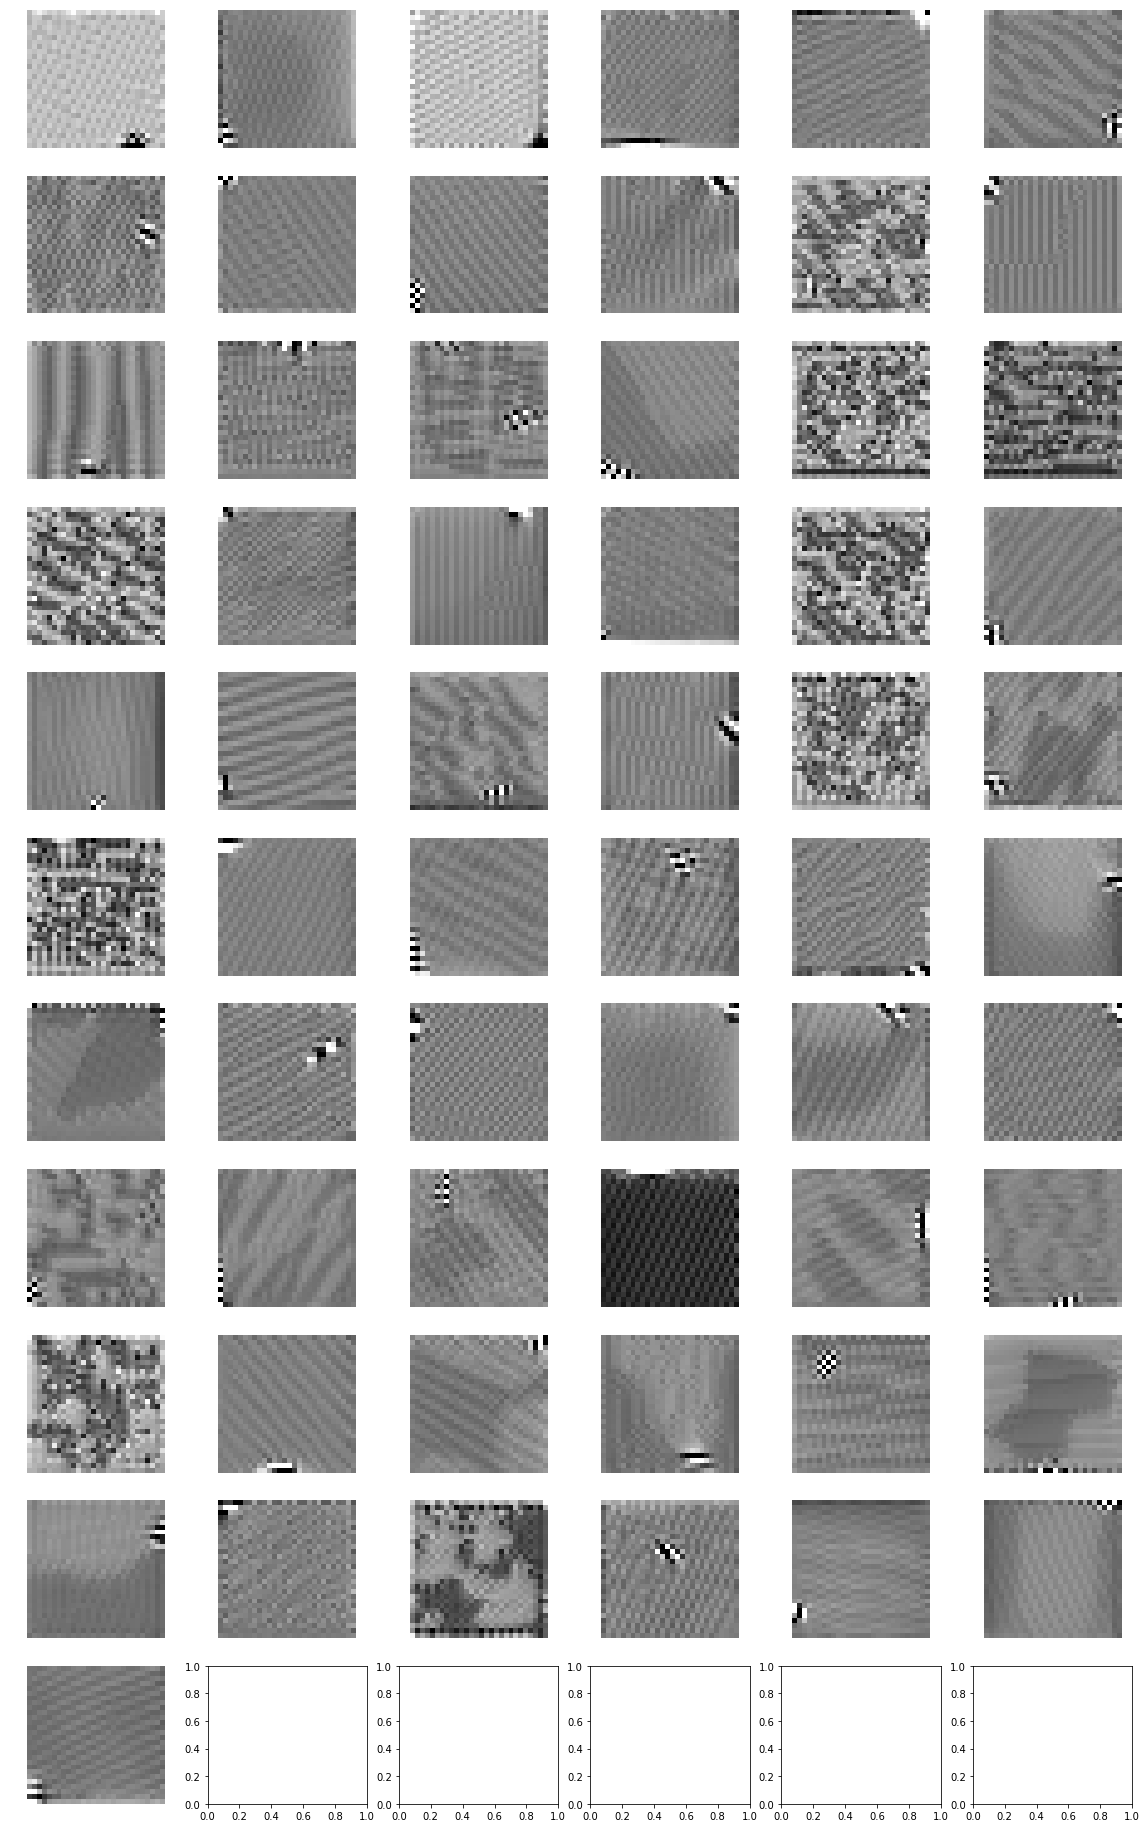

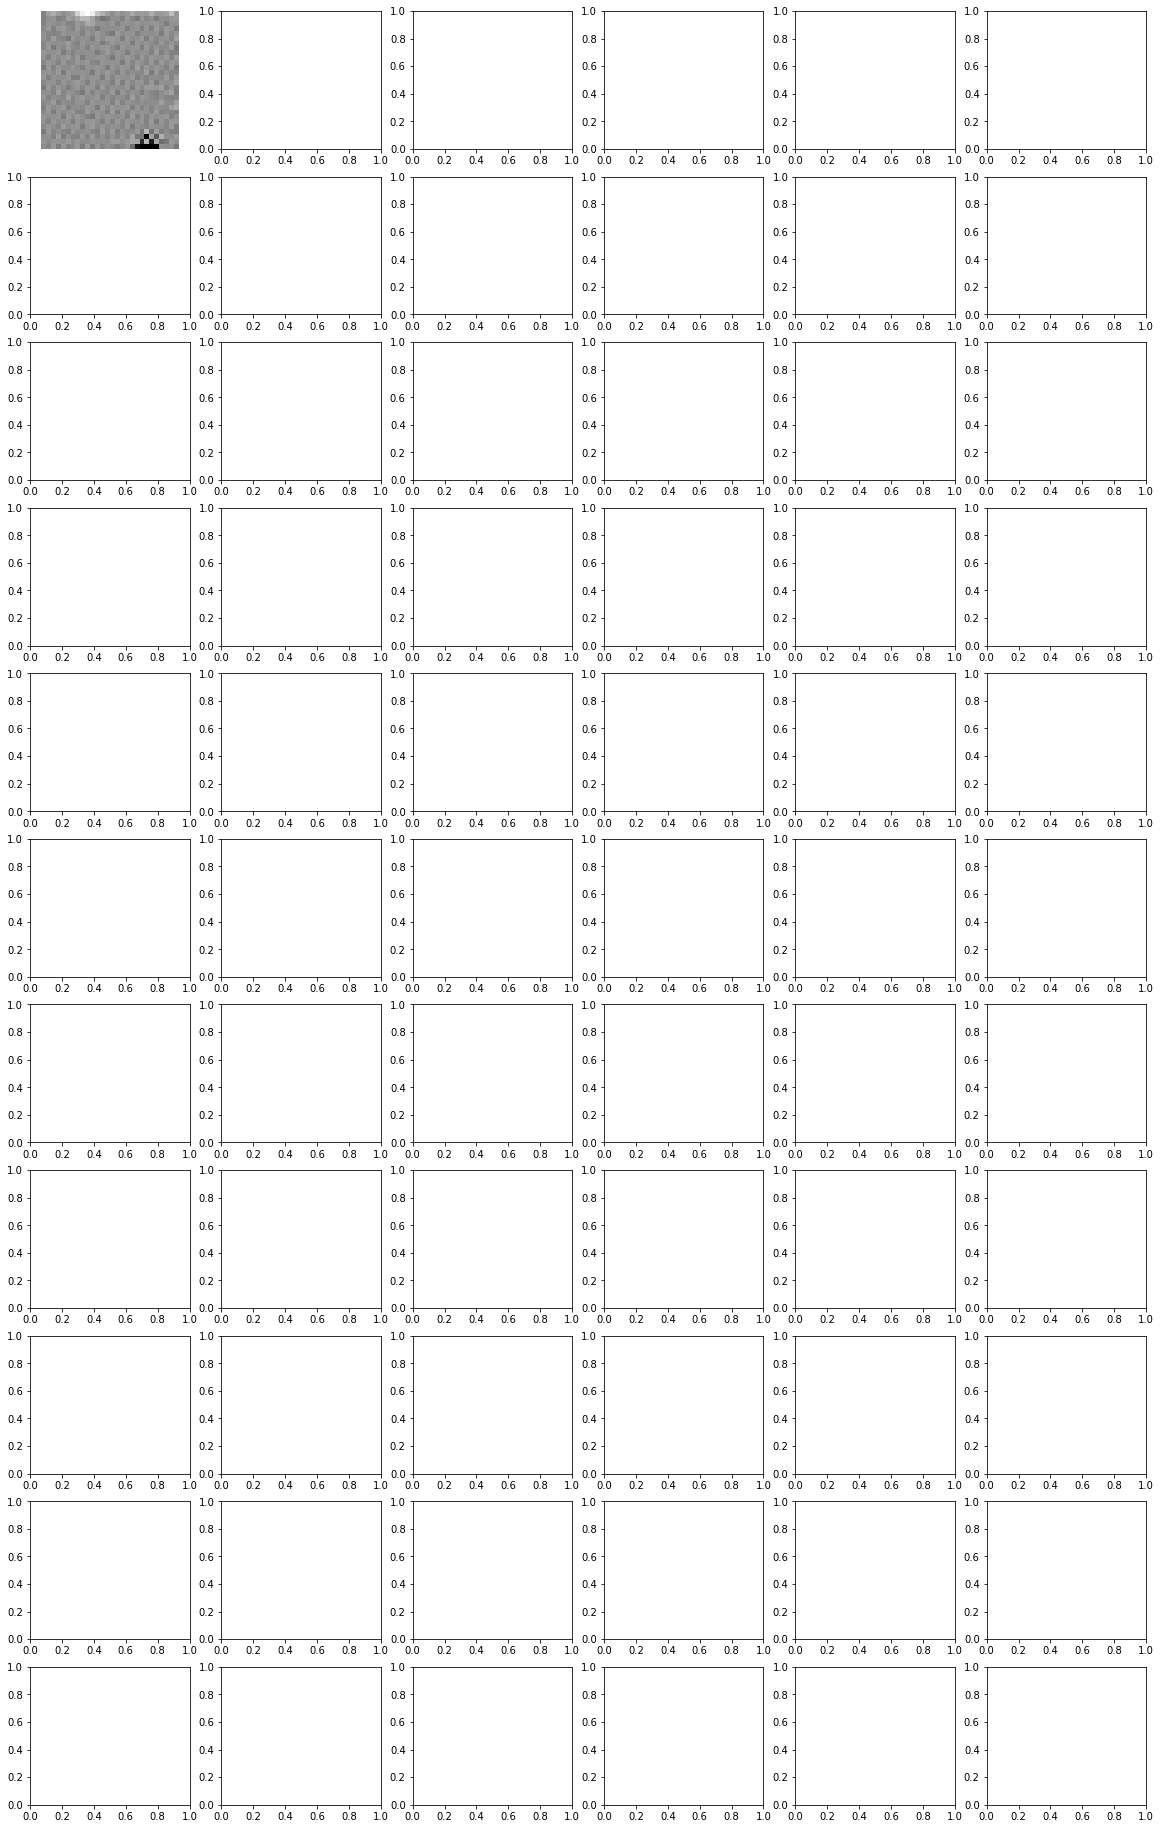

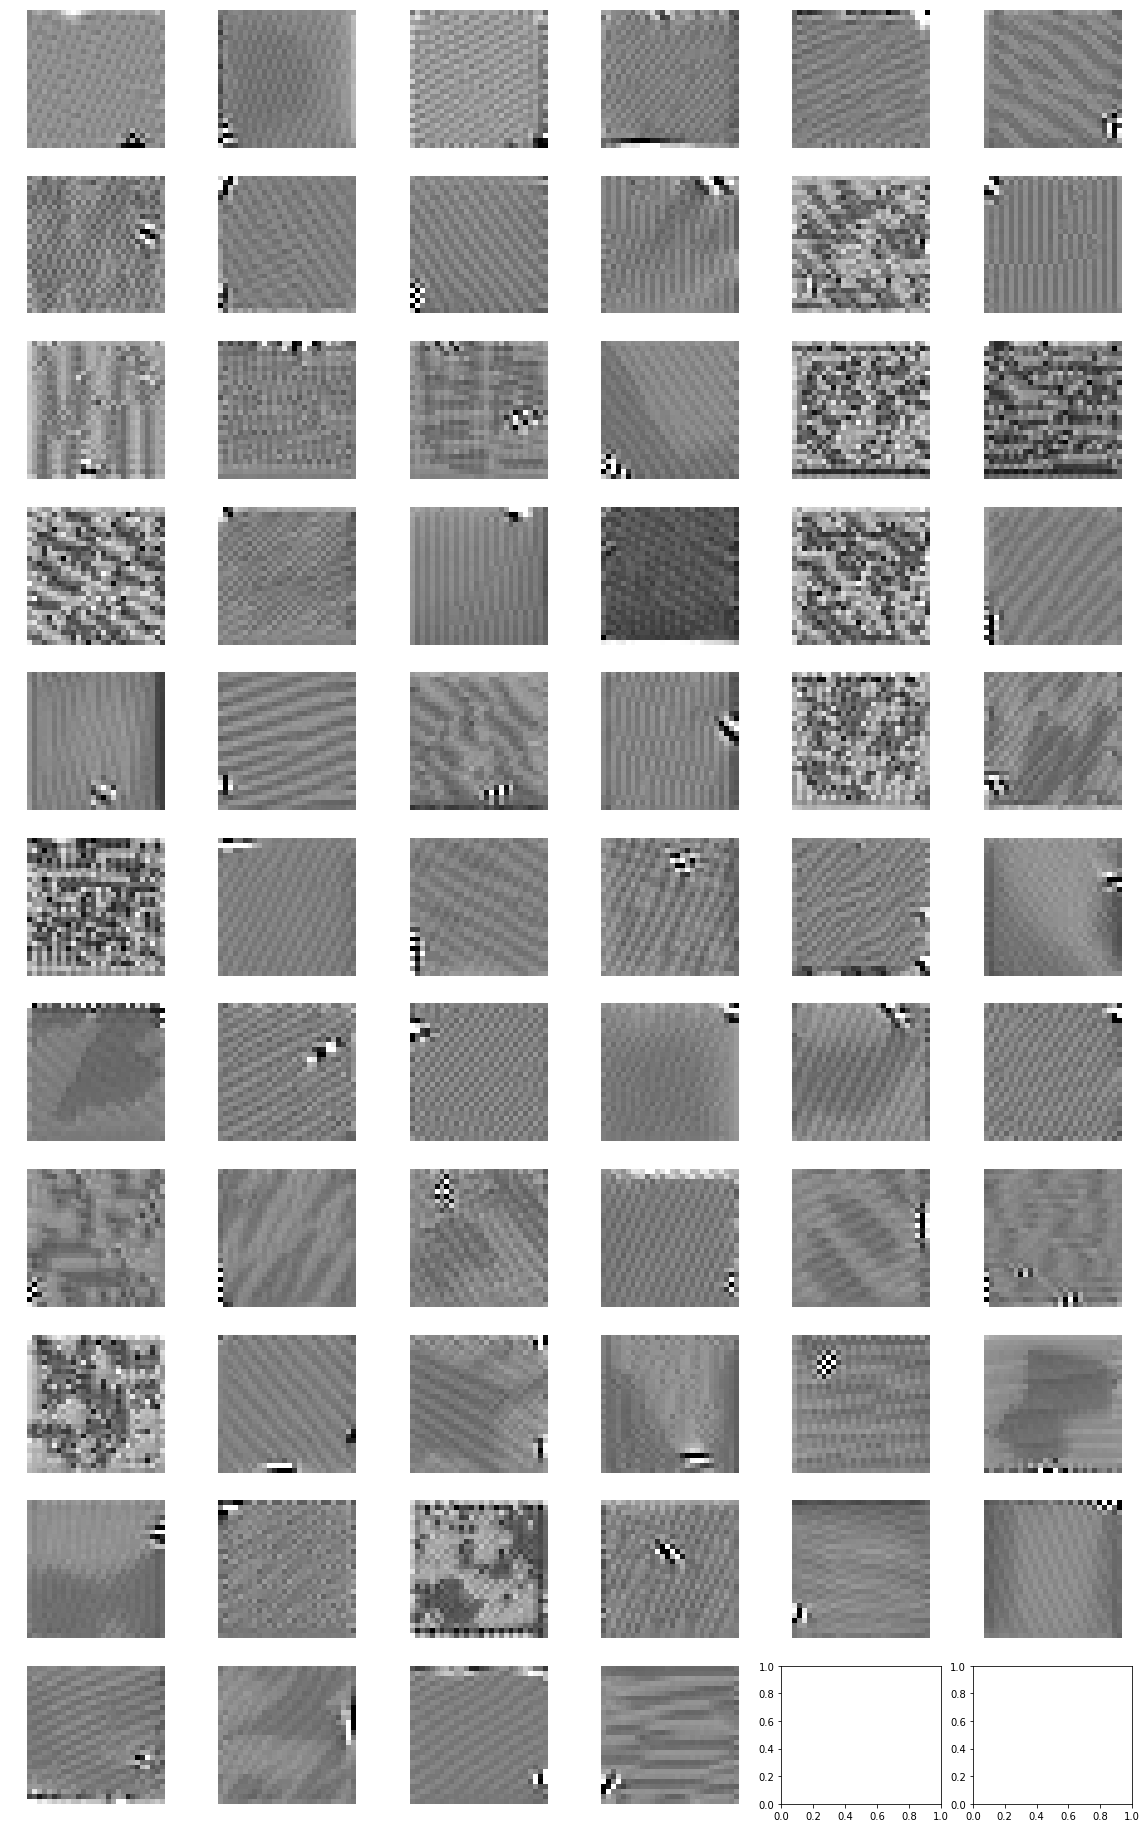

In [232]:
images = plot_conv_filters(model_4, 'Conv2', input_img_data, iterations=100, step = 100)

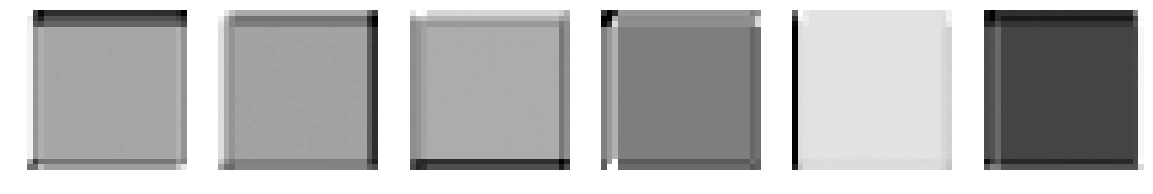

In [50]:
images = plot_conv_filters(model_1, 'Conv1', input_img_data, iterations=1500, step = 1)

In [11]:
from keras import backend as K
import numpy as np

from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    # x = x.transpose((1, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

def do_gradient_ascent(model, layer_name, filter_index, input_img_data_raw, step = 1, deprocess_image_flag=True, iterations = 20, img_width = 28, img_height = 28):
    global grad_glob
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if type(layer_dict[layer_name]) == keras.layers.convolutional.Conv2D:
        loss = K.mean(layer_output[:, :, :, filter_index])
    else:
        loss = K.mean(model.output[:, filter_index])
    input_img = model.input

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    # https://stats.stackexchange.com/questions/22568/difference-in-using-normalized-gradient-and-gradient
    grads = normalize(grads)
    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    
    # run gradient ascent for 20 steps
    input_img_data = input_img_data_raw.copy()
    for i in range(iterations):
        loss_value, grads_value = iterate([input_img_data])
        grad_glob = grads_value
        #print(grads_value.shape)
        input_img_data += grads_value * step
        #step = step*0.99
        
    if deprocess_image_flag:
        img_raw = input_img_data[0].reshape(img_width, img_height)
        img = deprocess_image(img_raw)
        return img
    else:
        return input_img_data

In [12]:
from matplotlib import pyplot as plt

In [13]:
def plot_conv_filters(model, layer_name, input_img_data, iterations=200, step = 1):
    # filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer
    # we start from a gray image with some noise
    # ax[0].imshow(input_img_data.reshape(img_width, img_height) , cmap='gray')
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    if type(layer_dict[layer_name]) == keras.layers.convolutional.Conv2D:
        filters = layer_dict[layer_name].filters
    elif type(layer_dict[layer_name]) == keras.layers.core.Dense:
        filters = layer_dict[layer_name].output_shape[-1]
    else:
        print('Not supported layer')
        return None
    filt_x = np.min([filters, 6])
    filt_y = int(np.ceil(filters / 6))
    f, ax = plt.subplots(filt_y, filt_x, figsize=(20,3*filt_y))
    ax = ax.reshape(-1)
    images = []
    for i in range(filters):
        img = do_gradient_ascent(model, layer_name, i, input_img_data, iterations=iterations, step=step)
        images.append(img)
        ax[i].axis('off')
        ax[i].imshow(img, cmap='gray')
    plt.show()
    return images

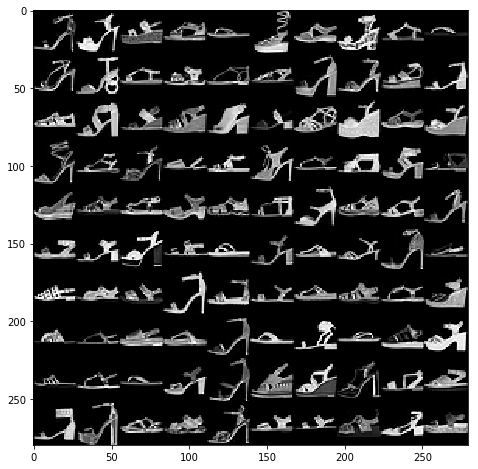

In [24]:
index = 5
plot_numbers(x[y==index],range(100), columns=10, figsize=(8, 8)) 

In [25]:
shirt = x[y==0][0].reshape(1,28,28,1)

In [16]:
img_width=28
img_height=28
input_img_data = (np.random.normal(0, 10, (1,img_width, img_height, 1))) + 128.
# input_img_data = (np.random.random((1, img_width, img_height, 1)) - 0.5) * 20 + 128
#index = 5
input_img_data_zapato = x[y==index][1].reshape(1,28,28,1)*1.0

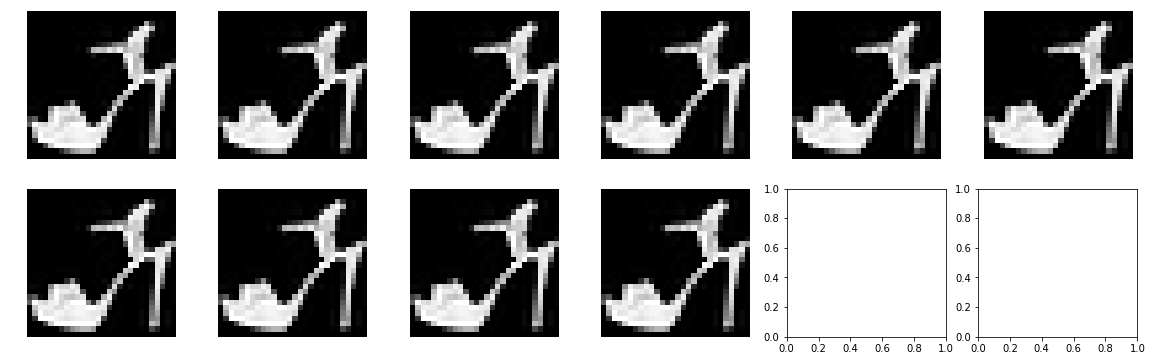

In [28]:
selected_model = model_1
_ = plot_conv_filters(selected_model, 'OutputLayer', input_img_data_zapato, iterations=500, step=10)

8
0.0923153
[[ 0.09231529  0.07358624  0.09997182  0.14353302  0.12414766  0.05945241
   0.08749394  0.09102862  0.15878735  0.06968357]]


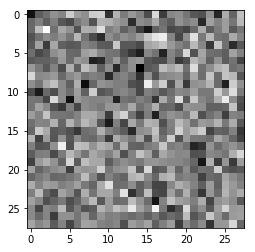

In [29]:
class_selection = 0
img = do_gradient_ascent(selected_model, 
                         'OutputLayer', 
                         class_selection, 
                         input_img_data, 
                         step = 50,
                         iterations = 100, 
                         deprocess_image_flag=False)
print(np.argmax(selected_model.predict(img)))
print(selected_model.predict(img)[0][class_selection])
print(selected_model.predict(img))
plt.imshow(deprocess_image(img.reshape(28,28)), cmap='gray')
plt.show()

# For model 1

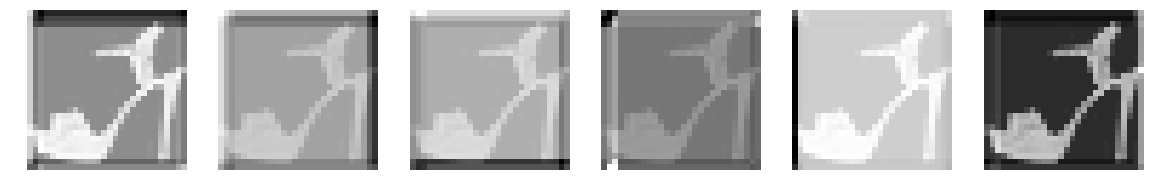

In [252]:
_ = plot_conv_filters(model_1, 'Conv1', input_img_data_zapato, iterations=200, step = 1)

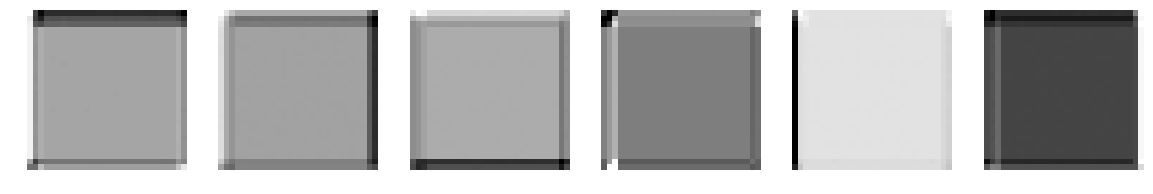

In [131]:
images = plot_conv_filters(model_1, 'Conv1', input_img_data, iterations=1500, step = 1)

123.115311909 0.319397985036


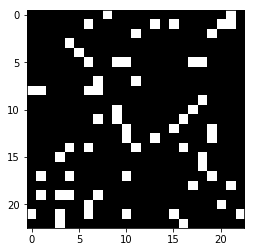

In [140]:
index = 5
image_an = images[index][3:-2,3:-2]
print(image_an.mean(), image_an.std())
plt.imshow(image_an, cmap='gray')
plt.show()

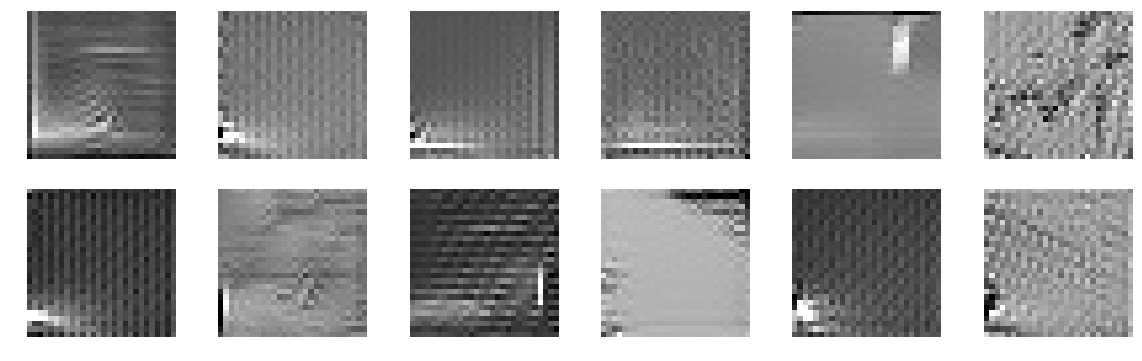

In [141]:
_ = plot_conv_filters(model_1, 'Conv2', input_img_data_zapato, iterations=1500, step = 1)

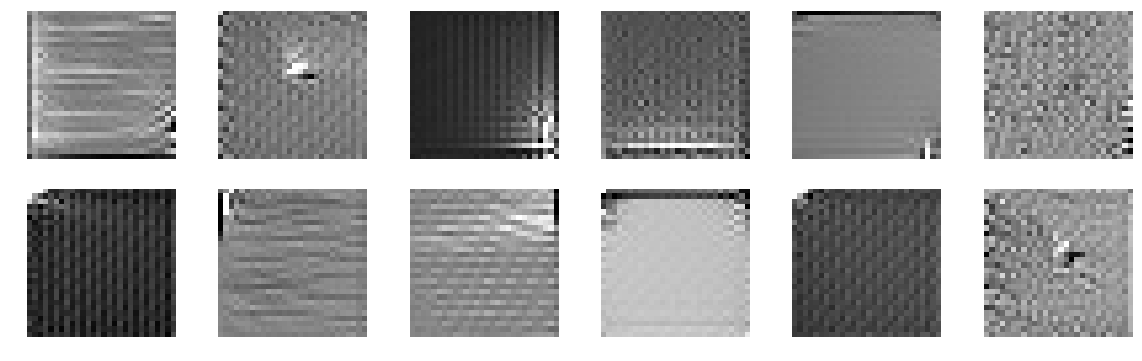

In [142]:
_ = plot_conv_filters(model_1, 'Conv2', input_img_data, iterations=1500, step = 1)

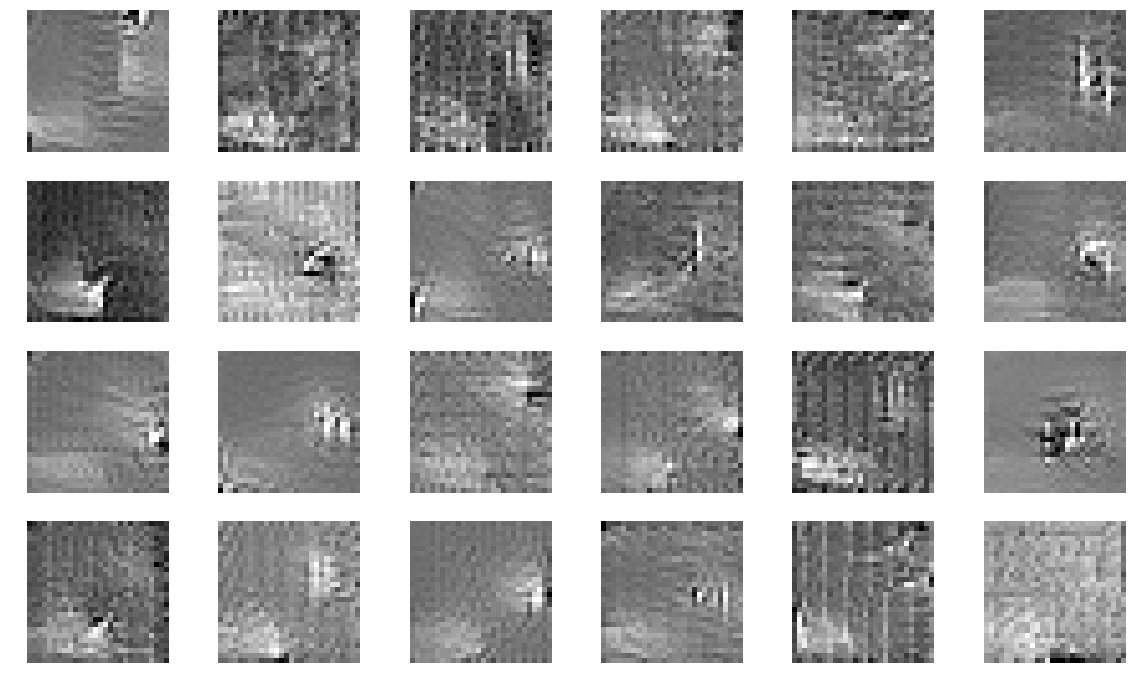

In [143]:
_ = plot_conv_filters(model_1, 'Conv3', input_img_data_zapato, iterations=1500,)

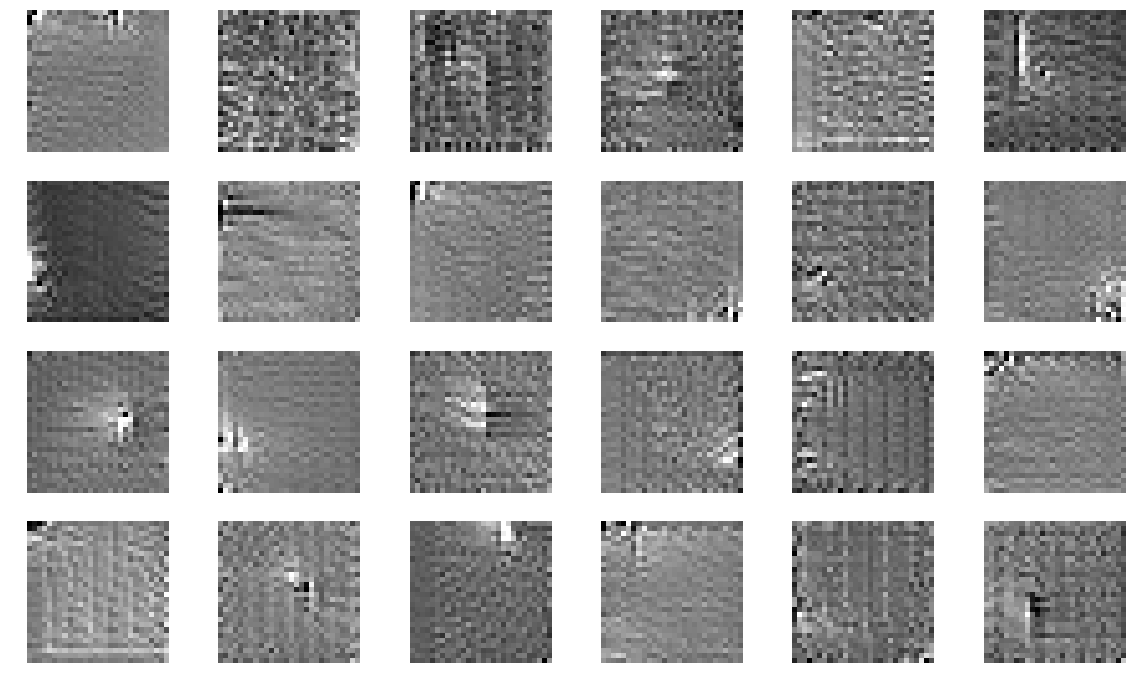

In [144]:
_ = plot_conv_filters(model_1, 'Conv3', input_img_data, iterations=1500,)

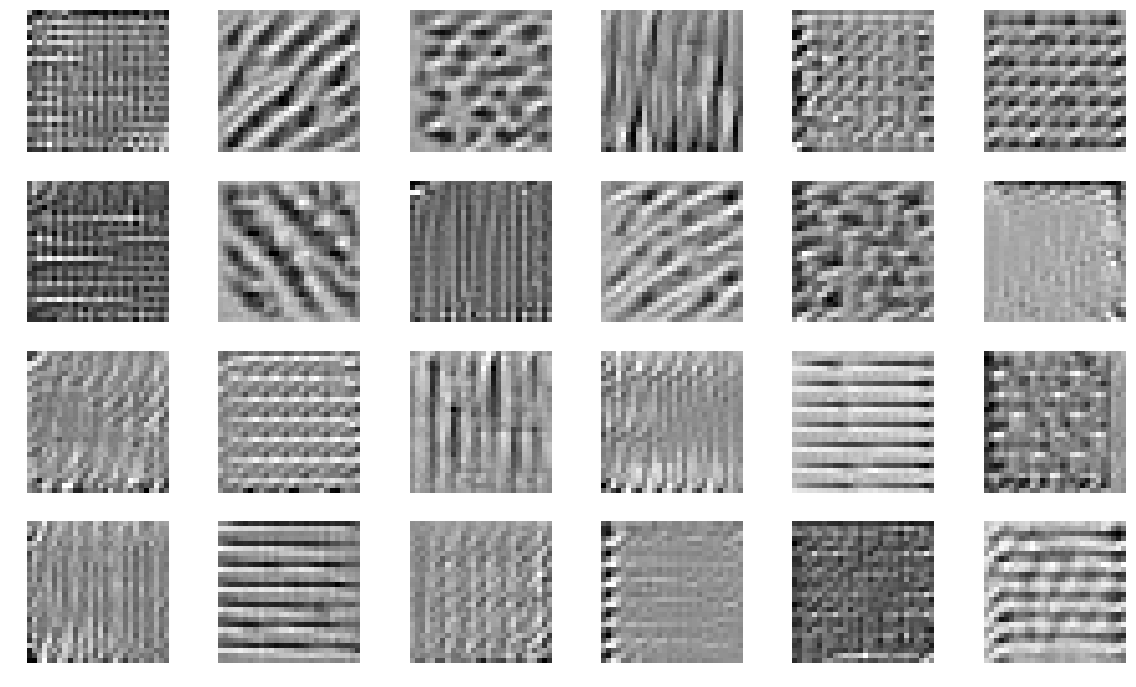

In [58]:
_ = plot_conv_filters(model_1, 'Conv3', input_img_data, step = 256)

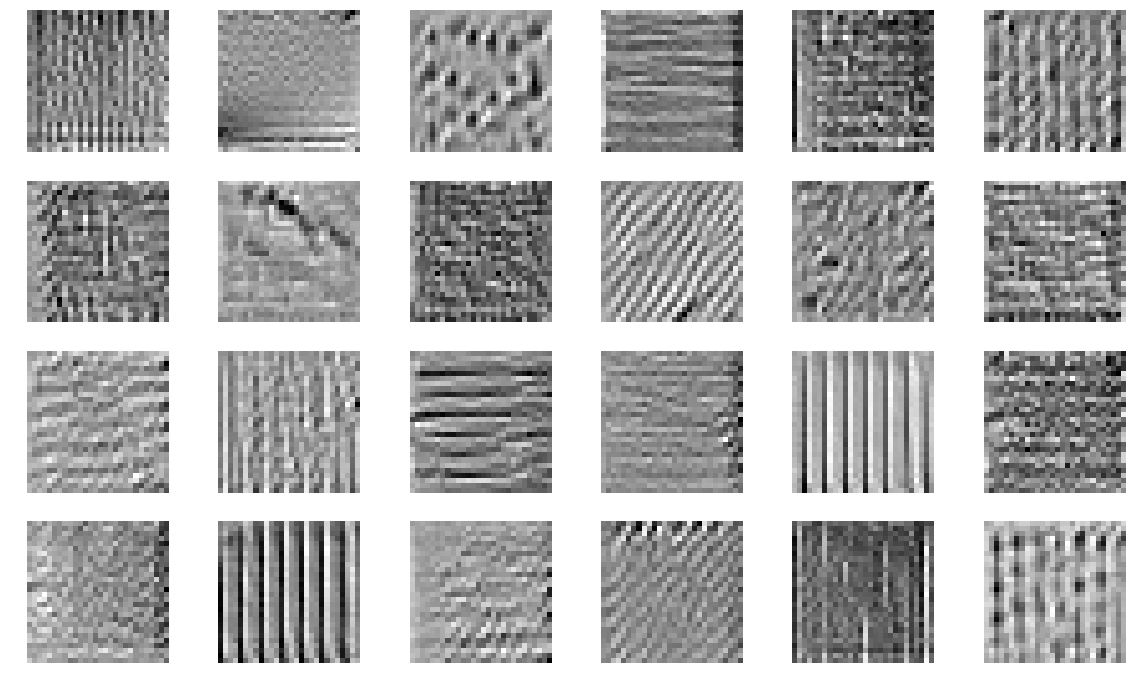

In [242]:
_ = plot_conv_filters(model_1, 'Conv3', input_img_data, step = 1)

# For model 2

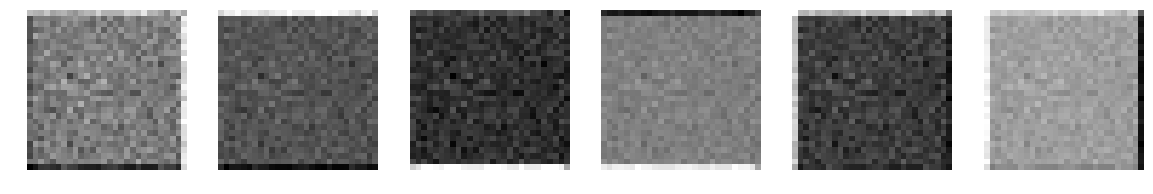

In [24]:
_ = plot_conv_filters(model_2, 'Conv1', input_img_data, iterations=500)

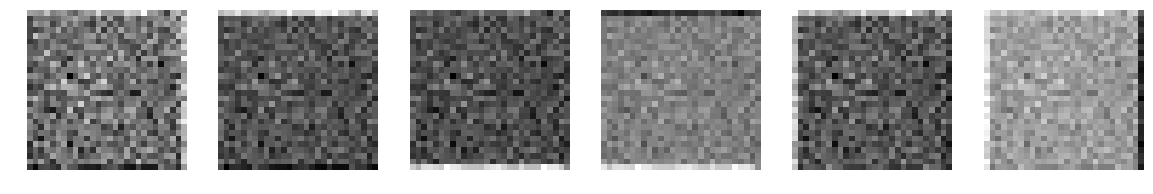

In [21]:
_ = plot_conv_filters(model_2, 'Conv1', input_img_data)

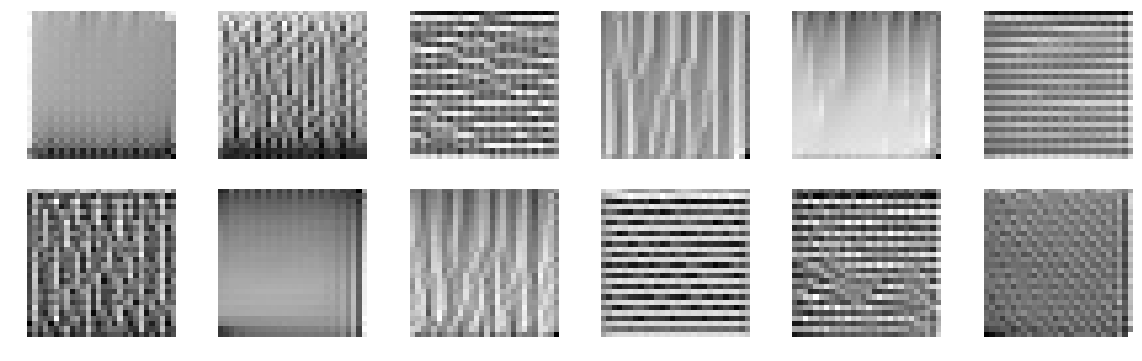

In [26]:
_ = plot_conv_filters(model_2, 'Conv2', input_img_data)

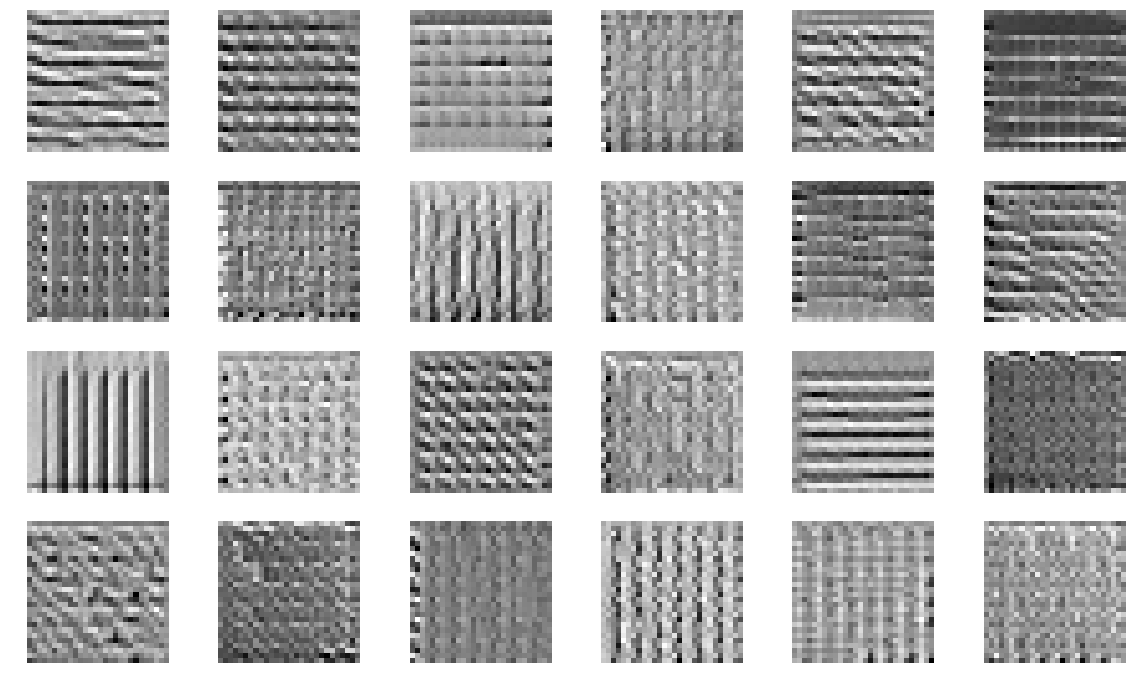

In [27]:
_ = plot_conv_filters(model_2, 'Conv3', input_img_data)

# For model 3

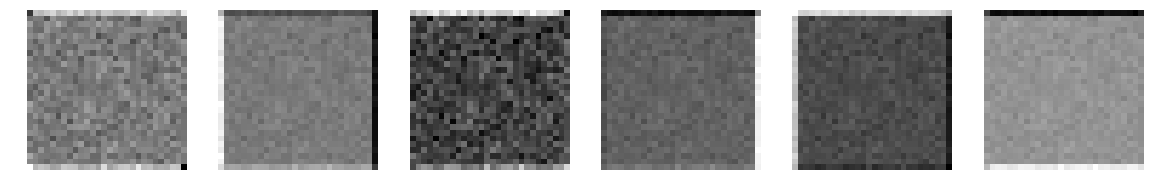

In [59]:
_ = plot_conv_filters(model_3, 'Conv1', input_img_data)

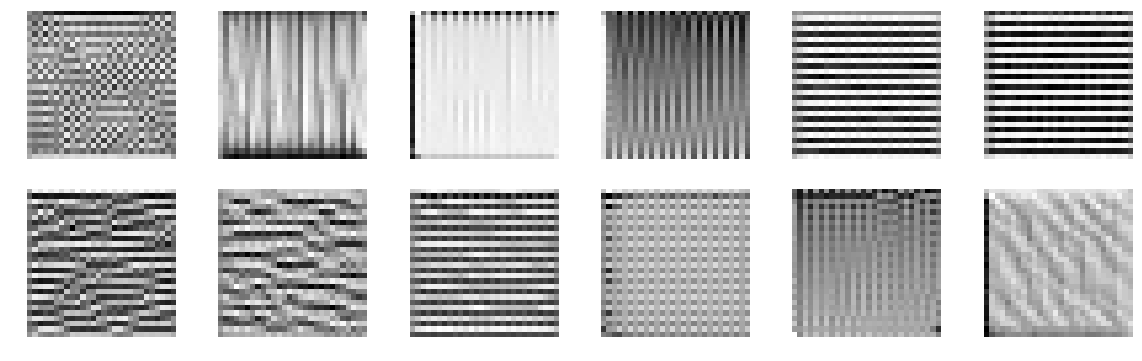

In [148]:
_ = plot_conv_filters(model_3, 'Conv2', input_img_data)

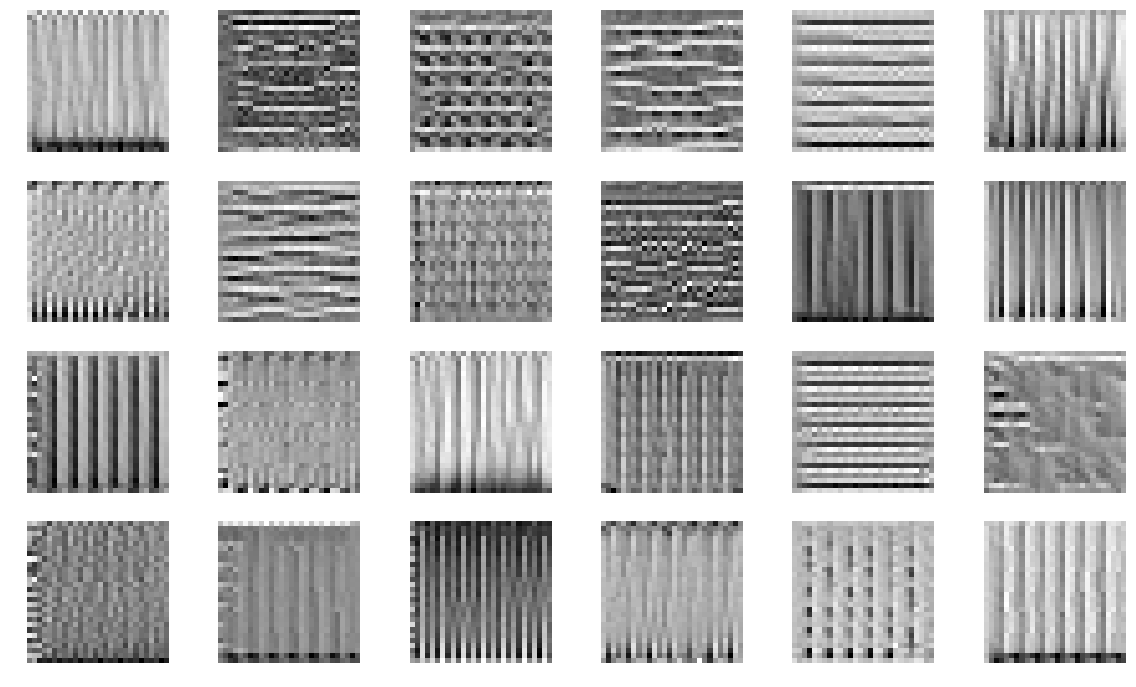

In [149]:
_ = plot_conv_filters(model_3, 'Conv3', input_img_data)

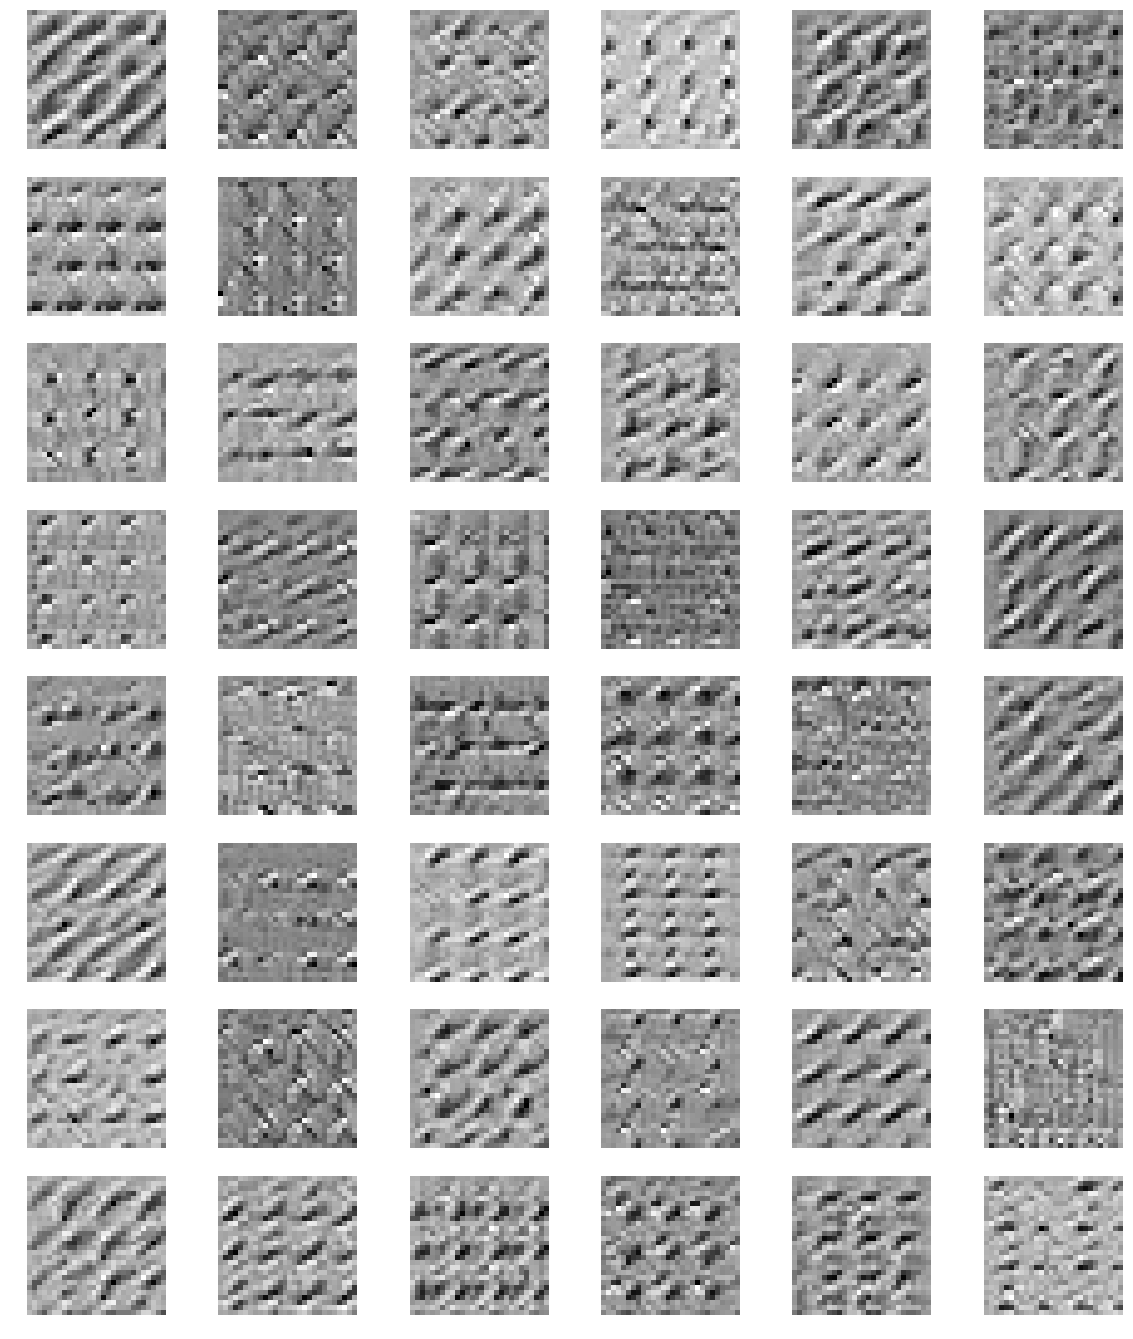

In [60]:
_ = plot_conv_filters(model_3, 'Conv4', input_img_data, step = 256)

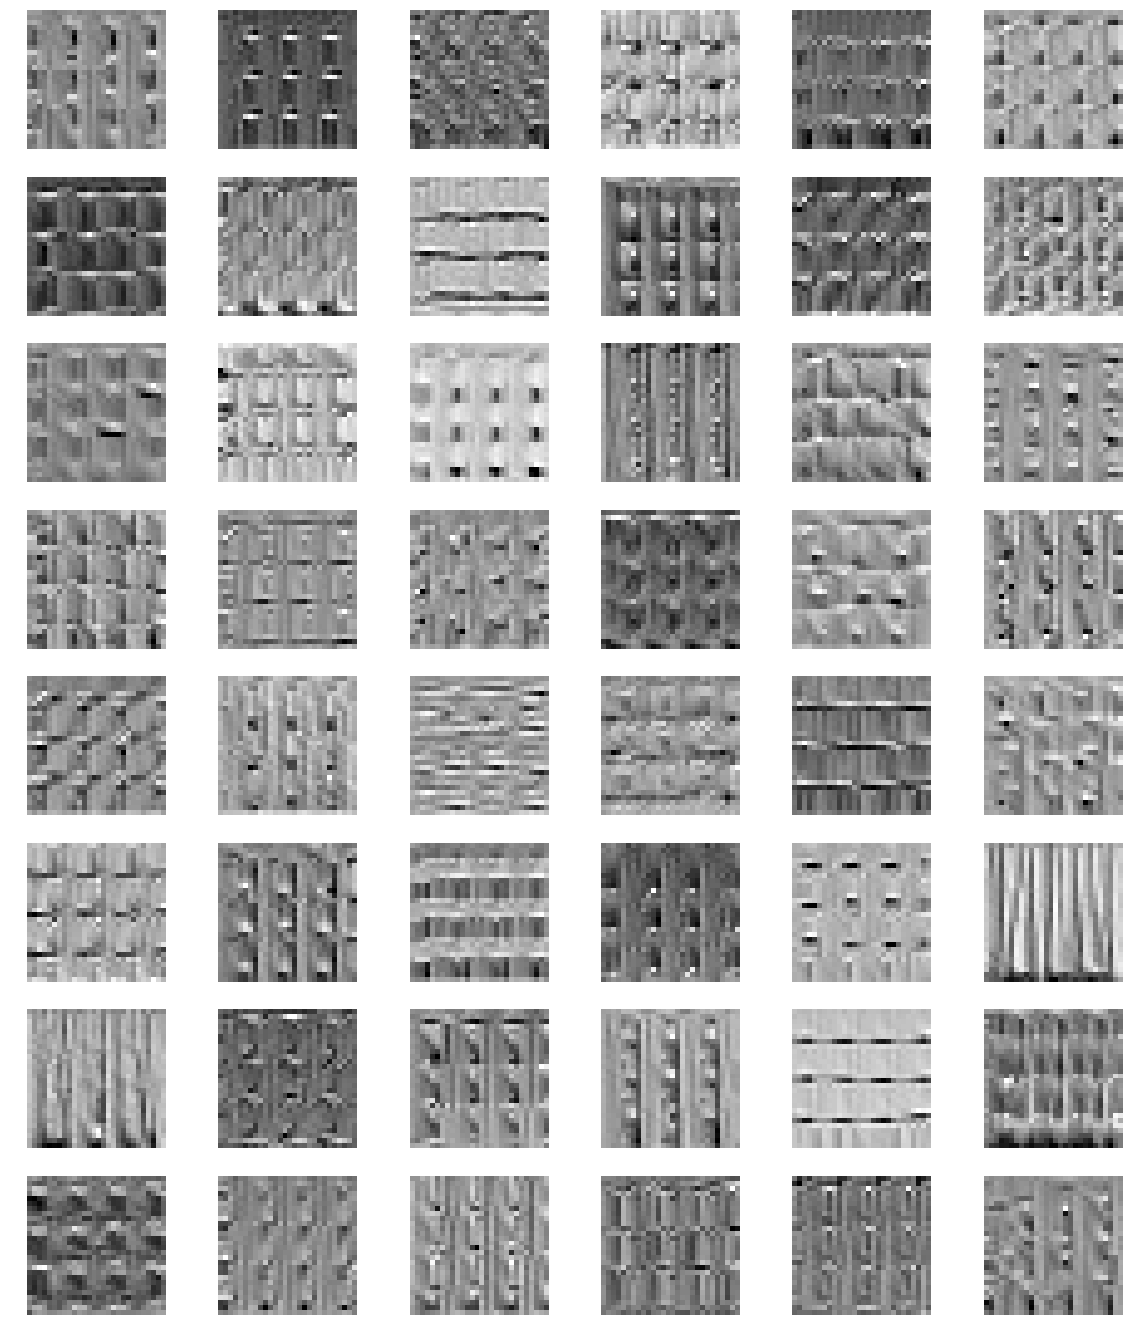

In [155]:
_ = plot_conv_filters(model_3, 'Conv4', input_img_data)